# Notes on calculation of the void-galaxy correlation function

A number of recent papers ([Cai *et al*. (2016)](https://arxiv.org/abs/1705.05328), [Nadathur & Percival (2019)](https://arxiv.org/abs/1712.07575), [Hamaus *et al*. 2020](https://arxiv.org/abs/2007.07895) etc.) obtain very different expressions for the predicted void-galaxy correlation function, *even though they are all derived from the same starting assumptions*. These authors also obtain different numerical results *when implementing the same expressions with close to identical input data*.

This is a worrying situation. Within the Euclid WP:Voids group there are two papers in preparation which disagree on the theory calculation as above. There is therefore a clear need for code validation and comparison between these groups to identify the cause of these differences before proceeding further.

This notebook provides a comparison of approaches and a public code implementation in order to help this validation. The code presented below may well have errors: if you see any please point them out as they may help resolve the differences between approaches.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.interpolate import InterpolatedUnivariateSpline, interp2d
from scipy.special import legendre
import matplotlib as mpl
%matplotlib inline

plt.style.use('seaborn-talk')

# Void RSD model

I provide a very brief summary of the model equations that are implemented in the code below. More details are to be found in the individual papers.

I denote the anisotropic void-galaxy correlation in redshift space by $\xi^s(\mathbf{s})$, where $\mathbf{s}$ is the vector between the void centre and galaxy. In real space, this separation vector is denoted $\mathbf{r}$, and $\xi(\mathbf{r})=\xi(r)$ is the isotropic real-space void-galaxy correlation. [Nadathur *et al*. 2019](https://arxiv.org/abs/1805.09349) noted that void selection effects can mean that in practice $\xi(\mathbf{r})$ may not be isotropic, but for the discussion in this notebook I ignore these complications and simply **assume** that $\xi(\mathbf{r})=\xi(r)$ holds.

At linear order in perturbation theory, assuming void positions are stationary but galaxies move, the RSD coordinate mapping is:

$$\mathbf{s} = \mathbf{r} - \frac{f}{3}\Delta(r)\mathbf{r}_{||},\;\;\;\;\;\;(1)$$

where $\Delta(r) = 3/r^3\int_0^r\delta(r^\prime){r^\prime}^2\;dr^\prime$ is the average matter density contrast of the void.

The conservation equation requires that

$$\left(1+\xi^s(\mathbf{s})\right) = \left(1+\xi(r)\right)\frac{\mathrm d^3r}{\mathrm d^3s},\;\;\;\;\;\;(2)$$

from which it follows that

$$\left(1+\xi^s(\mathbf{s})\right) = \left(1+\xi(r)\right)\left[1-\frac{f}{3}\Delta(r)-f\mu^2\left(\delta(r)-\Delta(r)\right)\right]^{-1},\;\;\;\;\;\;(3)$$

where $\mu=\frac{r_{||}}{r}$ is the cosine of the angle between $\mathbf{r}$ and the line-of-sight direction. This is Eq. (13) of [Nadathur & Percival (2019)](https://arxiv.org/abs/1712.07575) and Eq. (2.25) of [Hamaus *et al*. 2020](https://arxiv.org/abs/2007.07895). This equation is derived purely from the conservation equation and the linear perturbation theory assumption $\mathbf{v} = -\frac{1}{3}faH\Delta(r)\mathbf{r}$ so all authors agree that it is correct.

In the rest of this notebook **we assume linear bias** for the void matter density profile, so that $\xi(r)=b\delta(r)$ and $\bar\xi(r)\equiv 3/r^3\int_0^r\xi(r^\prime){r^\prime}^2\;dr^\prime=b\Delta(r)$. Then the complete expression becomes

$$\left(1+\xi^s(\mathbf{s})\right) = \left(1+\xi(r)\right)\left[1-\frac{1}{3}\frac{f}{b}\bar{\xi}(r)-\frac{f}{b}\mu^2\left(\xi(r)-\bar{\xi}(r)\right)\right]^{-1}.\;\;\;\;\;\;(4)$$

Here $\xi^s(\mathbf{s})=\xi^s(s_\perp,s_{||})=\xi^s(s,\mu^s)$ and

$$r_{||} = \frac{s_{||}}{1-\frac{1}{3}\frac{f}{b}\bar{\xi}(r)},\;\;\;r_\perp=s_\perp,\;\;\;\;\;\;(5)$$

so that $s=\frac{r}{1+\frac{1}{3}\frac{f}{b}\bar\xi(r)\mu^2}$.

Again, [Nadathur & Percival (2019)](https://arxiv.org/abs/1712.07575) and [Hamaus *et al*. 2020](https://arxiv.org/abs/2007.07895) both agree on the derivation of Eqs. (4) and (5) given the stated assumptions. The other papers also implicitly agree with this even if sometimes these equations do not appear explicitly in the text. These equations therefore represent the *complete model* without approximations.

## Approximations to the full calculation

Different authors however use different approximations to practically implement Eqs. (4) and (5) above.

### Series expansion

[Hamaus *et al*. 2020](https://arxiv.org/abs/2007.07895) perform a series expansion of the RHS of Eq. (4), keeping only terms of linear order in $\xi$ to obtain 

$$\xi^s(\mathbf{s}) \simeq \xi(r)+\frac{1}{3}\frac{f}{b}\bar\xi(r)+\frac{f}{b}\mu^2\left[\xi(r)-\bar\xi(r)\right],\;\;\;\;\;\;(6)$$

which is their Eq. (2.32). This approximation replaces Eq. (4) (which is Eq. (2.31) of [Hamaus *et al*. 2020](https://arxiv.org/abs/2007.07895)), and Eq. (5) remains as before. 

In contrast, [Nadathur & Percival (2019)](https://arxiv.org/abs/1712.07575) keep some higher order terms in the series expansion, and [Nadathur *et al*. (2020)](https://arxiv.org/abs/2008.06060) simply use Eq. (4) directly without approximation.

### Possible typo?

Eq. (18) in the draft of the WP:Voids paper currently reads (setting $\mathcal{M}=\mathcal{Q}=1$ for easy comparison to the equations above):

$$\xi^s(\mathbf{s}) \simeq \xi(r)+\frac{f}{b}\bar\xi(r)+2\frac{f}{b}\mu^2\left[\xi(r)-\bar\xi(r)\right].\;\;\;\;\;\;(6a)$$

Note that this does not match any of the expressions from any of the papers above, as there is a factor of $1/3$ missing from the second term and an additional factor of 2 in front of the $\mu^2$ term. I have not seen this equation before and no special derivation of it is provided. It does not match Eq. (7) in the same draft, or the equivalent expression in previous papers, so I presume it is simply a typo. However, see below!

### Coordinates

[Cai *et al*. (2016)](https://arxiv.org/abs/1705.05328) and [Hamaus *et al*. 2017](https://arxiv.org/abs/1705.05328) use the above series expansion and *also* further approximate the LHS of Eq. (6), writing

$$\xi^s(r,\mu) \simeq \xi(r)+\frac{1}{3}\frac{f}{b}\bar\xi(r)+\frac{f}{b}\mu^2\left[\xi(r)-\bar\xi(r)\right],\;\;\;\;\;\;(7)$$

**i.e., ignoring the shift in coordinates in the argument by assuming** $\xi^s(s,\mu^s) \simeq \xi^s(r,\mu)$ on the LHS, and not applying Eq. (5). 

[Nadathur & Percival (2019)](https://arxiv.org/abs/1712.07575) were the first to argue this approximation was inaccurate, and subsequently [Hamaus *et al*. 2020](https://arxiv.org/abs/2007.07895) and the current WP:Voids paper drafts also use the correct Eq. (5) instead.

### Closed-form expression for multipoles

Under the approximation of Eq. (7), the monopole and quadrupole moments of $\xi^s$ can be written as:

$$\xi^s_0(r) = \left(1+\frac{f/b}{3}\right)\xi(r),\;\;\;\;\;\;(8)$$

and

$$\xi^s_2(r) = \frac{2f}{3b}\left(\xi(r)-\bar\xi(r)\right).\;\;\;\;\;\;(9)$$

However, these expressions **do not hold** for the more general case of Eq. (6) (and definitely not for Eq. (4)). I don't derive the general expressions here, but approximations can be found in Eqs. (22) and (23) of [Nadathur & Percival (2019)](https://arxiv.org/abs/1712.07575).


# Code

We now write a simple function to calculate $\xi^s$ based on the above equations. I have written the function to be generally useful so it includes the possibility of Alcock-Paczynski distortions not included in the equations above, and also allows for optional use of the additional nuisance parameters $\mathcal{M}$ and $\mathcal{Q}$ introduced by [Hamaus *et al*. 2020](https://arxiv.org/abs/2007.07895). 

*Note*: all of the expressions above apply also if the void distances are rescaled in units of the void radius, $r\rightarrow r/R_v$. If the data for input function $\xi(r)$ is presented with argument rescaled as $r/R_v$, the output will automatically be given as $\xi^s(s/R_v, \mu^s)$; otherwise $h^{-1}$Mpc units will be used for both.

In [2]:
def xi_s_theory(xi_r_dat, s, mu, beta, epsilon=1, M=1.0, Q=1.0, niter=5, approx=False):
    """
    Calculates anisotropic redshift space correlation function
    
    Parameters:
    ----------
        xi_r_dat: 2D array specifying input function xi(r) as a lookup table. Column 0 contains 
                  a vector of r values, column 1 contains xi(r)
        
        s: observed amplitude of redshift-space separation vector at which to calculate result
        
        mu: cosine of angle of observed redshift-space separation vector to line-of-sight
        
        beta: RSD parameter, =f/b
        
        epsilon: Alcock-Paczynski parameter, =D_A/D_H (default = 1)
        
        M: additional monopole multiplicative parameter from Hamaus et al (default = 1)
        
        Q: additional quadrupole multiplicative parameter from Hamaus et al (default = 1)
        
        niter: number of iterations for real-to-redshift coordinate correction (default=5, set 
               to 0 to disable coordinate correction)
        
        approx: boolean, whether to drop higher terms in series expansion or use full expression 
                (default False)
        
    Returns:
    -------
        Predicted redshift space correlation xi^s(s, mu)
    """
    
    assert np.ndim(xi_r_dat) == 2, "xi_r_dat argument must be a 2D array"
 
    # read the data on the real-space xi(r), measured in fiducial coordinates
    r = xi_r_dat[:, 0]  # this column could be either r in Mpc/h or dimensionless r/R
    xi_r = xi_r_dat[:, 1]  # correspondingly, this column is either xi(r) or xi(r/R)
    
    # apply Alcock-Paczynski correction by rescaling the radial coordinate
    mu_vals = np.linspace(1e-3, 1)
    mu_integral = np.trapz(epsilon**(-2/3) * np.sqrt(1 + (1 - mu_vals**2) * (epsilon**2 - 1)), mu_vals)
    r  = r * mu_integral  # this is now r in the true cosmology

    # build an interpolation for xi(r)
    # if AP correction is applied, this is actually xi(r_true) where r_true is 
    # measured in the true cosmology
    xi_r_interp = InterpolatedUnivariateSpline(r, xi_r)
    
    # integrate xi(r) to obtain integral version of function (= b\Delta(r)) 
    integral = np.zeros(r.shape[0])
    for i in range(len(integral)):
        integral[i] = quad(lambda x: xi_r_interp(x) * x**2, 0, r[i], full_output=1)[0]
    bar_xi_r = InterpolatedUnivariateSpline(r, 3 * integral / r**3, ext=3)

    # apply AP corrections to get redshift-space coordinates (true_s, true_mu) in true 
    # cosmology from (s, mu) in fiducial cosmology
    true_mu = mu
    true_mu[mu>0] = 1 / np.sqrt(1 + epsilon**2 * (1 / mu[mu>0]**2 - 1)) 
    true_sperp = s * np.sqrt(1 - true_mu**2) * epsilon**(1/3)  
    true_spar = s * true_mu * epsilon**(-2/3)
    true_s = np.sqrt(true_spar**2 + true_sperp**2)
    # note that the variable name is left as mu for convenience, but this refers to 
    # \mu^s in equations above
    
    # now convert from redshift-space to real-space coordinates using iterative solver
    if niter > 0:
        r_par = true_spar / (1 - beta * M * bar_xi_r(true_s) / 3)
        for i in range(niter):
            r = np.sqrt(true_sperp**2 + r_par**2)
            r_par = true_spar / (1 - beta * M * bar_xi_r(r) / 3)
        r = np.sqrt(true_sperp**2 + r_par**2)
    else:
        # include option to not perform coordinate shift, as done in some papers
        r_par = true_spar
        r = true_s
    
    # recalculate the real-space \mu from \mu^s (keeping the same variable name for simplicity)
    true_mu = r_par / r
    # actually the above step is superfluous since \mu = \mu^s to very good accuracy
    
    # calculate the predicted xi^s
    if approx:
        # use approximation of Eq. (6)
        xi_s_model = M * (xi_r_interp(r) + beta * bar_xi_r(r) / 3 + 
                          Q * beta * true_mu**2 * (xi_r_interp(r) - bar_xi_r(r)))
    else:
        # use full expression of Eq. (5)
        xi_s_model = (1 + M * xi_r_interp(r)) / (1 - beta * bar_xi_r(r) / 3 - 
                                                 Q * beta * true_mu**2 * (xi_r_interp(r) - bar_xi_r(r))) - 1
        
    return xi_s_model


Now we add a small utility to calculate the Legendre multipoles of the full anisotropic correlation function: 

In [3]:
def multipoles(xirmu, r, ell=0):
    """
    Utility function to calculate the Legendre multipoles of a correlation function xi(r, mu)
    """

    output = np.zeros(len(r))
    lmu = legendre(ell)
    for i in range(len(r)):
            output[i] = quad(lambda x: xirmu(r[i], x) * lmu(x) * (2 * ell + 1), 0, 1, full_output=1)[0]

    return output


And we're ready to run some tests!

# Tests

In order to test the code we need to supply an input reference real-space correlation function $\xi(r)$. 

I load data from file that is chosen to closely match the $\xi(r)$ shown in Fig. 2 of the WP:Voids paper 2 draft ($\bar{Z}=1.00$ bin). However the test can be repeated with any input $\xi(r)$ data of your choice as it is the same for all the scenarios tested.

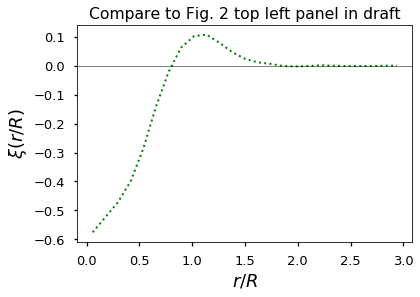

In [4]:
# load real-space correlation data from file
xi_r = np.loadtxt('reference_data/xi_r_wpv2_z1.0.txt')

# visualise the data to confirm it looks as expected
plt.plot(xi_r[:, 0], xi_r[:, 1], c='green', lw=2, ls=':')
plt.axhline(0, c='k', ls='-', lw=0.5)
plt.xlabel(r'$r/R$', fontsize=18)
plt.ylabel(r'$\xi(r/R)$', fontsize=18)
plt.title('Compare to Fig. 2 top left panel in draft');

Now I calculate the monopole $\xi^s_0(s)$ and quadrupole $\xi^s_2(s)$ moments of the full anisotropic redshift-space correlation. I will use an illustrative value of the RSD parameter $\beta = 0.5$, and set $\epsilon=1$ (no AP distortion) and $\mathcal{M}=\mathcal{Q}=1$ (no additional nuisance parameters).

**Case 1**: The full "*complete model*" calculation using Eqs. (4) and (5):

In [5]:
# set RSD beta parameter
beta = 0.5

# create coordinate mesh
s_grid = np.linspace(0.1, 2.9) # note: rescaled in units s/R to match input
mu_grid = np.linspace(0, 1)
s, mu = np.meshgrid(s_grid, mu_grid)

xi_s_full = xi_s_theory(xi_r, s, mu, beta, approx=False)
xismu = interp2d(s_grid, mu_grid, xi_s_full, kind='cubic')
monopole_full = multipoles(xismu, s_grid, ell=0)
quadrupole_full = multipoles(xismu, s_grid, ell=2)

**Case 2:** The "*series expansion*" approximation, using Eq. (6) and Eq. (5):

In [6]:
xi_s_series = xi_s_theory(xi_r, s, mu, beta, approx=True)
xismu = interp2d(s_grid, mu_grid, xi_s_series, kind='cubic')
monopole_series = multipoles(xismu, s_grid, ell=0)
quadrupole_series = multipoles(xismu, s_grid, ell=2)

**Case 3:** The "*early approximation*" from the first papers on the topic, that uses Eq. (7) only (i.e. that combines the series expansion approximation and the $\xi^s(s,\mu^s)\simeq\xi^s(r,\mu)$ approximation):

In [7]:
xi_s_orig = xi_s_theory(xi_r, s, mu, beta, niter=0, approx=True)
xismu = interp2d(s_grid, mu_grid, xi_s_orig, kind='cubic')
monopole_orig = multipoles(xismu, s_grid, ell=0)
quadrupole_orig = multipoles(xismu, s_grid, ell=2)

**Case 4:** Direct analytic approximations for $\xi^s_0$ and $\xi^s_2$ from Eqs. (8) and (9):

In [8]:
xi_r_interp = InterpolatedUnivariateSpline(xi_r[:, 0], xi_r[:, 1])
integral = np.zeros(xi_r.shape[0])
for i in range(len(integral)):
    integral[i] = quad(lambda x: xi_r_interp(x) * x**2, 0, xi_r[i, 0], full_output=1)[0]
bar_xi_r_interp = InterpolatedUnivariateSpline(xi_r[:, 0], 3 * integral / xi_r[:, 0]**3, ext=3)

monopole_analytic = (1 + beta/3) * xi_r_interp(s_grid)
quadrupole_analytic = 2 * beta * (xi_r_interp(s_grid) - bar_xi_r_interp(s_grid)) / 3 

## Comparing calculation methods

First let's plot the predicted monopoles.

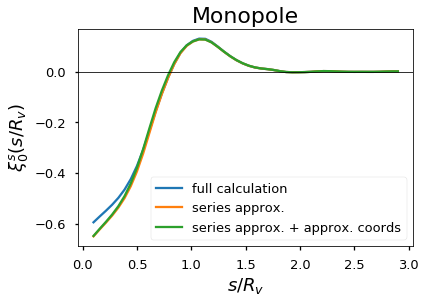

In [9]:
# plt.figure(figsize=(8,6))
plt.plot(s_grid, monopole_full, label='full calculation')
plt.plot(s_grid, monopole_series, label=r'series approx.')
plt.plot(s_grid, monopole_orig, label=r'series approx. + approx. coords')
plt.axhline(0, c='k', lw=0.8)
plt.legend(loc='lower right')
plt.xlabel(r'$s/R_v$', fontsize=18)
plt.ylabel(r'$\xi^s_0(s/R_v)$', fontsize=18)
plt.title('Monopole', fontsize=22);

Near the void centres, $s<0.5R_v$, the use of the truncated series expansion leads to significant errors in the monopole. The effect of the approximated coordinates is smaller.

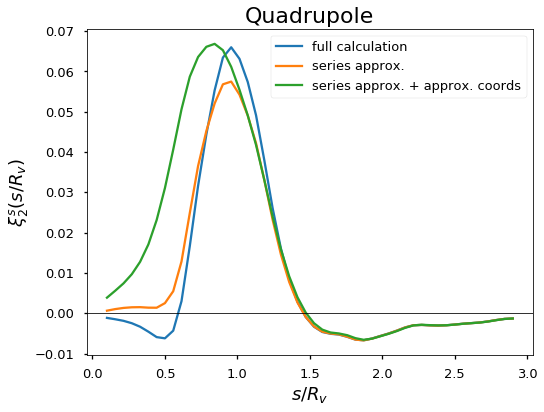

In [10]:
plt.figure(figsize=(8,6))
plt.plot(s_grid, quadrupole_full, label='full calculation')
plt.plot(s_grid, quadrupole_series, label=r'series approx.')
plt.plot(s_grid, quadrupole_orig, label=r'series approx. + approx. coords')
plt.axhline(0, c='k', lw=0.8)
plt.legend(loc='upper right')
plt.xlabel(r'$s/R_v$', fontsize=18)
plt.ylabel(r'$\xi^s_2(s/R_v)$', fontsize=18)
plt.title('Quadrupole', fontsize=22);

In the quadrupole calculation the effect of the series truncation is large over the entire void interior, $s\lesssim 1.5R_v$. The effect of the coordinate approximation is even larger over the range $s\lesssim R_v$. Remember that in both the above plots, the blue lines are the results of implementing the full equations that all authors agree to be correct, and orange and green are approximations to this.

*Notice the characteristic behaviour of the full calculation*: $\xi^s_2(s/R_v)<0$ for $s\lesssim0.5R_v$ and then changes sign. This is generically *always* expected to occur because a negative quadrupole corresponds to the underdense region appearing stretched along the line of sight in redshift space, as pointed out by [Nadathur & Percival (2019)](https://arxiv.org/abs/1712.07575), and as expected in a Kaiser picture for an underdense region.

As expected, the closed-form expression of Eq. (9) exactly matches the quadrupole calculated from Eq. (7), but does not match the correct expression:

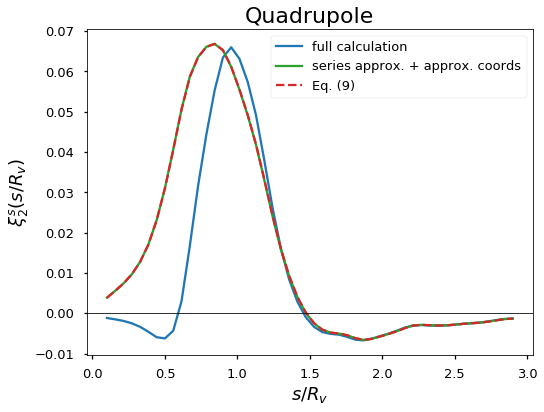

In [11]:
plt.figure(figsize=(8,6))
plt.plot(s_grid, quadrupole_full, label='full calculation')
plt.plot(s_grid, quadrupole_orig, c='C2', label=r'series approx. + approx. coords')
plt.plot(s_grid, quadrupole_analytic, c='C3', ls='--', label=r'Eq. (9)')
plt.axhline(0, c='k', lw=0.8)
plt.legend(loc='upper right')
plt.xlabel(r'$s/R_v$', fontsize=18)
plt.ylabel(r'$\xi^s_2(s/R_v)$', fontsize=18)
plt.title('Quadrupole', fontsize=22);

# First conclusion

Unless there is some identifiable error in the code above:

1. The approximate equations provided in [Hamaus *et al*. 2020](https://arxiv.org/abs/2007.07895) and the current WP:Voids paper draft do not match the results of implementing the full expression derived in these papers, and

2. The previous approximations used by [Cai *et al*. (2016)](https://arxiv.org/abs/1705.05328) and [Hamaus *et al*. 2017](https://arxiv.org/abs/1705.05328) are not consistent with **either** those of [Hamaus *et al*. 2020](https://arxiv.org/abs/2007.07895) and the current WP:Voids paper draft **or** the full expression.


# Checking results in the WP:Voids draft paper

So far I have compared my own implementations of the different approximations used in the literature to calculate $\xi^s(\mathbf{s})$ to results from using the full expression. 

Now I want to compare the results of my implementations with those obtained in these papers. I start with the current WP:Voids paper draft, and then look at [Hamaus *et al*. 2020](https://arxiv.org/abs/2007.07895).

## Load approximate data

I load data from file that approximately matches the best-fit monopole and quadrupole outputs obtained in the current WP:Voids draft shown in Fig. (3) ($\bar{Z}=1.00$, top right panel). The match is only approximate so no precise comparisons should be done, but this gives a good qualitative picture.

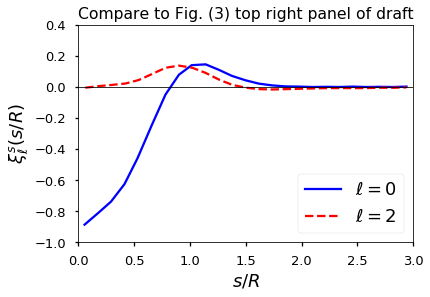

In [12]:
paper_mono = np.loadtxt('reference_data/xi_s_mono_th_wpv2_z1.0.txt')
paper_quad = np.loadtxt('reference_data/xi_s_quad_th_wpv2_z1.0.txt')

# plt.figure(figsize=(8,6))
plt.plot(paper_mono[:, 0], paper_mono[:, 1], c='blue', label=r'$\ell=0$')
plt.plot(paper_quad[:, 0], paper_quad[:, 1], c='red', ls='--', label=r'$\ell=2$')
plt.axhline(0, c='k', lw=0.8)
plt.xlim(0, 3)
plt.ylim(-1, 0.4)
plt.xlabel(r'$s/R$', fontsize=18)
plt.ylabel(r'$\xi^s_\ell(s/R)$', fontsize=18)
plt.legend(loc='lower right', fontsize=18)
plt.title('Compare to Fig. (3) top right panel of draft');

Now I use input parameters $\beta=0.532$, $\epsilon=1.0080$, $\mathcal{M}=0.988$ and $\mathcal{Q}=1.107$ approximately corresponding to the best-fit values shown in the top left panel of Fig. (4) in the draft. I then calculate the theory multipoles using the code above (obtained from using both the fully correct Eq. (4) as well as the approximate implementation Eq. (6)) and compare to the results in the draft. 

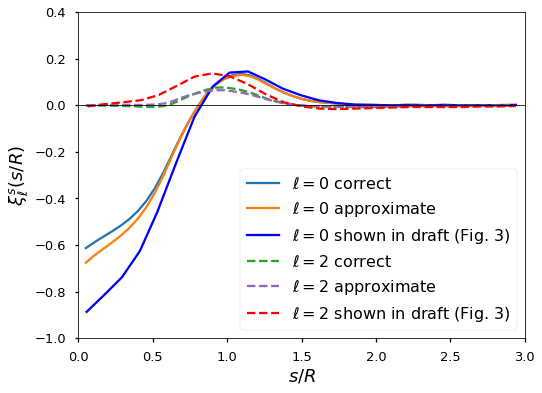

In [13]:
# set RSD beta parameter
beta = 0.532
eps = 1.0080
m = 0.988
q = 1.107

# create coordinate mesh
s_grid = np.linspace(0.05, 2.9)
mu_grid = np.linspace(0, 1)
s, mu = np.meshgrid(s_grid, mu_grid)

xi_s_full = xi_s_theory(xi_r, s, mu, beta, epsilon=eps, M=m, Q=q, approx=False)
xismu = interp2d(s_grid, mu_grid, xi_s_full, kind='cubic')
monopole_full = multipoles(xismu, s_grid, ell=0)
quadrupole_full = multipoles(xismu, s_grid, ell=2)

xi_s_series = xi_s_theory(xi_r, s, mu, beta, epsilon=eps, M=m, Q=q, approx=True)
xismu = interp2d(s_grid, mu_grid, xi_s_series, kind='cubic')
monopole_series = multipoles(xismu, s_grid, ell=0)
quadrupole_series = multipoles(xismu, s_grid, ell=2)

# visualise the differences
plt.figure(figsize=(8,6))
plt.plot(s_grid, monopole_full, label=r'$\ell=0$ correct')
plt.plot(s_grid, monopole_series, label=r'$\ell=0$ approximate')
plt.plot(paper_mono[:, 0], paper_mono[:, 1], c='blue', label=r'$\ell=0$ shown in draft (Fig. 3)')
plt.plot(s_grid, quadrupole_full, ls='--', label='$\ell=2$ correct')
plt.plot(s_grid, quadrupole_series, ls='--', c='C4', label='$\ell=2$ approximate')
plt.plot(paper_quad[:, 0], paper_quad[:, 1], c='red', ls='--', label=r'$\ell=2$ shown in draft (Fig. 3)')
plt.axhline(0, c='k', lw=0.8)
plt.xlim(0, 3)
plt.ylim(-1, 0.4)
plt.xlabel(r'$s/R$', fontsize=18)
plt.ylabel(r'$\xi^s_\ell(s/R)$', fontsize=18)
plt.legend(loc='lower right', fontsize=16)

**Neither the full expression nor the approximation intended in the theory section of the draft paper match the result actually presented in the draft.** The differences are very large, far exceeding the errors on the measured data over all scales.

## A (partial) explanation for the discrepancy 

**Assumptions**: I am going to assume that Eq. (6a) was used instead of Eq. (6) in the draft. I am further going to assume that Eq. (5) was in fact not applied even though it is clearly stated in the draft that it was. The justification for these assumptions is given below.

Note that if including the $\mathcal{M}$ and $\mathcal{Q}$ nuisance parameters, Eq. (6) becomes

$$\xi^s(\mathbf{s}) \simeq \mathcal{M}\left[\xi(r)+\frac{1}{3}\frac{f}{b}\bar\xi(r)+\mathcal{Q}\frac{f}{b}\mu^2\left[\xi(r)-\bar\xi(r)\right]\right],\;\;\;\;\;\;(6)$$

while Eq. (6a) is

$$\xi^s(\mathbf{s}) \simeq \mathcal{M}\left[\xi(r)+\frac{f}{b}\bar\xi(r)+2\mathcal{Q}\frac{f}{b}\mu^2\left[\xi(r)-\bar\xi(r)\right]\right].\;\;\;\;\;\;(6a)$$

Therefore the result of Eq. (6a) can be obtained by changing input parameters $f/b\rightarrow 3f/b$ and $\mathcal{Q}\rightarrow 2\mathcal{Q}/3$ in Eq. (6). Similarly Eq. (5) can be simply disapplied by setting parameter ```niter=0``` in the call to the function ```xi_s_theory```.


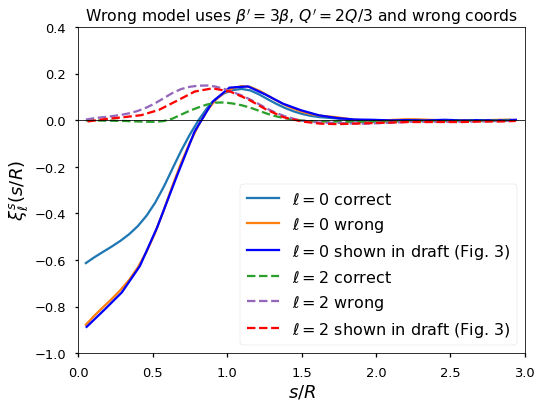

In [14]:
# ensure we start with the same parameters as before
beta = 0.532
eps = 1.0080
m = 0.988
q = 1.107

xi_s_wrong = xi_s_theory(xi_r, s, mu, 3*beta, epsilon=eps, M=m, Q=2*q/3, niter=0, approx=True)
xismu = interp2d(s_grid, mu_grid, xi_s_wrong, kind='cubic')
monopole_wrong = multipoles(xismu, s_grid, ell=0)
quadrupole_wrong = multipoles(xismu, s_grid, ell=2)

# Replot
plt.figure(figsize=(8,6))
plt.plot(s_grid, monopole_full, label=r'$\ell=0$ correct')
plt.plot(s_grid, monopole_wrong, label=r'$\ell=0$ wrong')
plt.plot(paper_mono[:, 0], paper_mono[:, 1], c='blue', label=r'$\ell=0$ shown in draft (Fig. 3)')
plt.plot(s_grid, quadrupole_full, ls='--', label='$\ell=2$ correct')
plt.plot(s_grid, quadrupole_wrong, ls='--', c='C4', label='$\ell=2$ wrong')
plt.plot(paper_quad[:, 0], paper_quad[:, 1], c='red', ls='--', label=r'$\ell=2$ shown in draft (Fig. 3)')
plt.axhline(0, c='k', lw=0.8)
plt.xlim(0, 3)
plt.ylim(-1, 0.4)
plt.xlabel(r'$s/R$', fontsize=18)
plt.ylabel(r'$\xi^s_\ell(s/R)$', fontsize=18)
plt.legend(loc='lower right', fontsize=16)
plt.title(r'Wrong model uses $\beta^\prime=3\beta$, $Q^\prime=2Q/3$ and wrong coords');

*The wrong model approximately reproduces the results in the draft paper!* The agreement is still not perfect, but there are several possible explanations for the remaining small differences – minor differences in the input $\xi(r/R)$ function, minor differences in the best-fit parameter values used etc. It is not necessary to check these right now, since it is already clear that this model is in any case wrong.

# Second conclusion

1. Contrary to what is stated in the draft text, it appears Eq. (19) of the draft (Eq. (5) in this notebook) is actually not applied.

2. The calculations used in the draft use the Eq. (18) as stated on page 5 (Eq. (6a) in this notebook) which seems to have important typos and is inconsistent with Eq. (2.32) of [Hamaus *et al*. 2020](https://arxiv.org/abs/2007.07895) (Eq. (6) in this notebook).

3. This means that (assuming the data vectors have been correctly measured from Flagship data) *at the minimum* the parameter constraints obtained from fits to Flagship data shown in the paper need to be changed according to
$$\left(\beta, \mathcal{Q}\right)\rightarrow\left(\beta^\prime, \mathcal{Q}^\prime\right) = \left(3\beta, \frac{2}{3}\mathcal{Q}\right)$$
This means there is approximately **a factor of three error** in the reported growth rate values!!

As an illustrative example, this would mean that the best-fit values obtained for the $\bar{Z}=1.00$ bin should instead be $f/b\simeq1.6$ and $\mathcal{Q}\simeq0.74$, which would be very far from the fiducial values. Systematic errors in other parameters might also occur.

Of course, since Eq. (19) was also not applied, and the series expansion approximation used has been shown above to be incomplete, these values are just guides and a full test of systematic effects should be performed from scratch.

# Checking the results of [Hamaus *et al*. 2020](https://arxiv.org/abs/2007.07895)

Given the above findings, I investigate also the results in [Hamaus *et al*. 2020](https://arxiv.org/abs/2007.07895). In this case I use input data for $\xi(r/R)$ that approximately matches the results shown in that paper for the Patchy mocks, in the green dotted line in Fig. 4 of that paper, and compare to functions that approximately match the monopole and quadrupole shown in Fig. 5. 

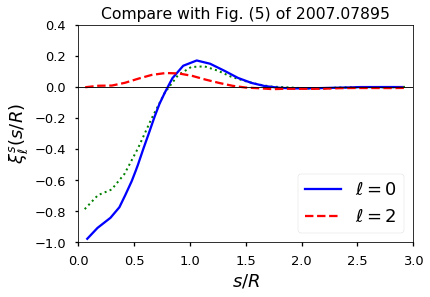

In [15]:
# load real-space correlation data from file
xi_r = np.loadtxt('reference_data/xi_r_Hamaus2020_Patchy.txt')

# visualise the data to confirm it looks as expected
# plt.figure(figsize=(8,6))
plt.plot(xi_r[:, 0], xi_r[:, 1], c='green', lw=2, ls=':')
plt.axhline(0, c='k', ls='-', lw=0.5)
plt.xlabel(r'$r/R$', fontsize=18)
plt.ylabel(r'$\xi(r/R)$', fontsize=18)
plt.title('Compare with right panel of Fig. (4) of 2007.07895')

# now load the monopole and quadrupole results
hamaus_mono = np.loadtxt('reference_data/xi_s_mono_th_Hamaus2020_Patchy.txt')
hamaus_quad = np.loadtxt('reference_data/xi_s_quad_th_Hamaus2020_Patchy.txt')

# and check that they look as expected
# plt.figure(figsize=(8,6))
plt.plot(hamaus_mono[:, 0], hamaus_mono[:, 1], c='blue', label=r'$\ell=0$')
plt.plot(hamaus_quad[:, 0], hamaus_quad[:, 1], c='red', ls='--', label=r'$\ell=2$')
plt.axhline(0, c='k', lw=0.8)
plt.xlim(0, 3)
plt.ylim(-1, 0.4)
plt.xlabel(r'$s/R$', fontsize=18)
plt.ylabel(r'$\xi^s_\ell(s/R)$', fontsize=18)
plt.legend(loc='lower right', fontsize=18)
plt.title('Compare with Fig. (5) of 2007.07895');

I now use input parameters $\beta=0.347$, $\epsilon=1.0058$, $\mathcal{M}=1.138$ and $\mathcal{Q}=1.22$ to match the approximate best-fit values reported in Fig. (6) of [Hamaus *et al*. 2020](https://arxiv.org/abs/2007.07895), and repeat the comparison. 

For simplicity in the figure below, I show only 
1. the result obtained using Eqs. (2.32) and (2.26) of [Hamaus *et al*. 2020](https://arxiv.org/abs/2007.07895), which correspond to Eqs. (6) and (5) in this notebook respectively, and 
2. the result if Eq. (5) is actually incorrectly not applied, i.e. using the "coordinate approximation" $\xi^s(s, \mu^s)=\xi^s(r, \mu)$ (achieved by setting ```niter=0```).

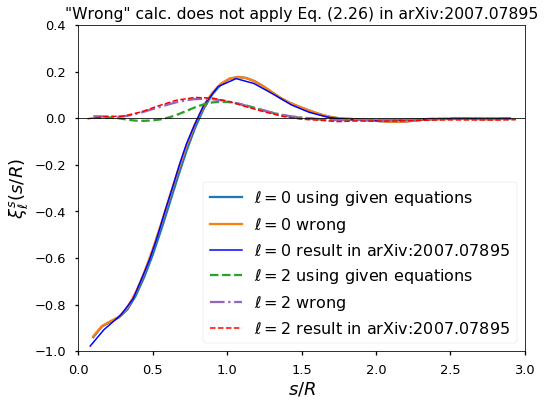

In [16]:
# set RSD beta parameter
beta = 0.347
eps = 1.0058
m = 1.138
q = 1.22

# create coordinate mesh
s_grid = np.linspace(0.1, 2.9)
mu_grid = np.linspace(0, 1)
s, mu = np.meshgrid(s_grid, mu_grid)

# the implementation stated by Hamaus et al, using Eqs. (6) and (5)
xi_s_series = xi_s_theory(xi_r, s, mu, beta, epsilon=eps, M=m, Q=q, approx=True)
xismu = interp2d(s_grid, mu_grid, xi_s_series, kind='cubic')
monopole_series = multipoles(xismu, s_grid, ell=0)
quadrupole_series = multipoles(xismu, s_grid, ell=2)

# the incorrect implementation, using Eq. (7)
xi_s_orig = xi_s_theory(xi_r, s, mu, beta, niter=0, epsilon=eps, M=m, Q=q, approx=True)
xismu = interp2d(s_grid, mu_grid, xi_s_orig, kind='cubic')
monopole_orig = multipoles(xismu, s_grid, ell=0)
quadrupole_orig = multipoles(xismu, s_grid, ell=2)

# visualise the differences
plt.figure(figsize=(8,6))
plt.plot(s_grid, monopole_series, label=r'$\ell=0$ using given equations')
plt.plot(s_grid, monopole_orig, label=r'$\ell=0$ wrong')
plt.plot(hamaus_mono[:, 0], hamaus_mono[:, 1], c='blue', lw=1.5, label=r'$\ell=0$ result in arXiv:2007.07895')
plt.plot(s_grid, quadrupole_series, ls='--', label='$\ell=2$ using given equations')
plt.plot(s_grid, quadrupole_orig, ls='-.', c='C4', label='$\ell=2$ wrong')
plt.plot(hamaus_quad[:, 0], hamaus_quad[:, 1], c='red', ls='--', lw=1.5, label=r'$\ell=2$ result in arXiv:2007.07895')
plt.axhline(0, c='k', lw=0.8)
plt.xlim(0, 3)
plt.ylim(-1, 0.4)
plt.xlabel(r'$s/R$', fontsize=18)
plt.ylabel(r'$\xi^s_\ell(s/R)$', fontsize=18)
plt.legend(loc='lower right', fontsize=16)
plt.title('"Wrong" calc. does not apply Eq. (2.26) in arXiv:2007.07895');

Using the model equations (2.32) and (2.26) stated in [Hamaus *et al*. 2020](https://arxiv.org/abs/2007.07895) I am **unable to reproduce their results** (especially in the quadrupole moment). However, by dropping the implementation of Eq. (2.26) stated in [Hamaus *et al*. 2020](https://arxiv.org/abs/2007.07895) (Eq. (5) in this notebook) I *can* reproduce their results.

For completeness, let's also look at the differences compared to the *correct* model, which corresponds to Eqs. (2.31) and (2.26) in [Hamaus *et al*. 2020](https://arxiv.org/abs/2007.07895), or Eqs. (4) and (5) in this notebook:

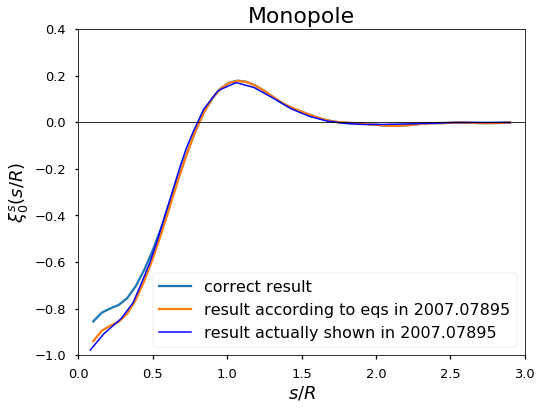

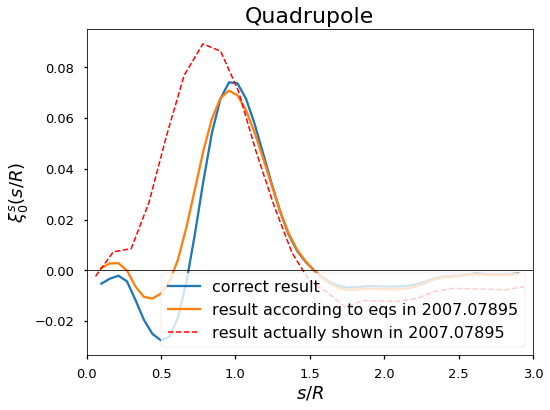

In [17]:
# the full correct model calculation, using Eqs. (4) and (5)
xi_s_full = xi_s_theory(xi_r, s, mu, beta, epsilon=eps, M=m, Q=q, approx=False)
xismu = interp2d(s_grid, mu_grid, xi_s_full, kind='cubic')
monopole_full = multipoles(xismu, s_grid, ell=0)
quadrupole_full = multipoles(xismu, s_grid, ell=2)

plt.figure(figsize=(8,6))
plt.plot(s_grid, monopole_full, label=r'correct result')
plt.plot(s_grid, monopole_series, label=r'result according to eqs in 2007.07895')
# plt.plot(s_grid, monopole_orig, label=r'result actually shown in 2007.07895')
plt.plot(hamaus_mono[:, 0], hamaus_mono[:, 1], c='blue', lw=1.5, label=r'result actually shown in 2007.07895')
plt.axhline(0, c='k', lw=0.8)
plt.xlim(0, 3)
plt.ylim(-1, 0.4)
plt.xlabel(r'$s/R$', fontsize=18)
plt.ylabel(r'$\xi^s_0(s/R)$', fontsize=18)
plt.legend(loc='lower right', fontsize=16)
plt.title('Monopole', fontsize=22);

plt.figure(figsize=(8,6))
plt.plot(s_grid, quadrupole_full, label=r'correct result')
plt.plot(s_grid, quadrupole_series, label=r'result according to eqs in 2007.07895')
# plt.plot(s_grid, quadrupole_orig, label=r'result actually shown in 2007.07895')
plt.plot(hamaus_quad[:, 0], hamaus_quad[:, 1], c='red', ls='--', lw=1.5, label=r'result actually shown in 2007.07895')
plt.axhline(0, c='k', lw=0.8)
plt.xlim(0, 3)
plt.xlabel(r'$s/R$', fontsize=18)
plt.ylabel(r'$\xi^s_0(s/R)$', fontsize=18)
plt.legend(loc='lower right', fontsize=16)
plt.title('Quadrupole', fontsize=22);

# Third conclusion

1. The results presented in [Hamaus *et al*. 2020](https://arxiv.org/abs/2007.07895) appear to be inconsistent with the equations (2.32) and (2.26) given in that paper – in particular it seems as though the iterative solution for Eq. (2.26) has actually not been applied as described.

2. In addition, Eq. (2.32) presented in [Hamaus *et al*. 2020](https://arxiv.org/abs/2007.07895) (Eq. (6) in this notebook) is itself an inaccurate approximation to the true model in their Eq. (2.31) (Eq. (4) in this notebook).

Given this, the constraints on cosmological parameters obtained by [Hamaus *et al*. 2020](https://arxiv.org/abs/2007.07895) should also be re-evaluated. 